# Recovering the Gauss coefficients of the Earth's magnetic field

The Earth's magnetic field is generated by convective motion in the liquid outer core. The nature of the magnetic field is characterised by long periods of stability, punctuated by abrupt reversals that remain poorly understood. To shed light onto the dynamics of outer-core convection, the evolution of the geomagnetic field needs to be reconstructed accurately.

More than 400 years ago, sparse magnetic data started to be collected during expeditions from Europe to other continents. Today, satellites provide measurements that are nearly continuous in time and space.

At any point in time, the radial component $B_r$ of the magnetic field at the Earth's surface can be represented by a *spherical harmonic expansion*

$$B_r=\sum_{n=0}^{\infty} \sum_{m=0}^n ( g_n^m \, \cos m\phi + h_n^m \, \sin m\phi)\, P_n^m(\cos \theta)\,,$$

where $\phi$ and $\theta$ denote longitude and colatitude, respectively. The $P_n^m$ are Legendre functions of *degree* $n$ and *order* $m$. The *spherical harmonic coefficients* $g_n^m$ and $h_n^m$ are commonly referred to as the *Gauss coefficients*. $$ $$

The current (as of 2015) Gauss coefficients that best fit magnetic field observations are described in the *International Geomagnetic Reference Field* (Thebault et al., 2015). The first few are tabulated below:

$g_1^0=-29442.0$

$g_1^1=-1501.0$

$h_1^1=4797.1$

$g_2^0=-2445.1$

$g_2^1=3012.9$

The goal of this series of exercises is to infer the spherical harmonic coefficients of the magnetic field from (artificial) observations of the magnetic field at a few locations on the surface of the Earth. This will serve to introduce important concepts such as the sampling of a (posterior) probability density, grid search, and the curse of dimensionality.

# 0. Import some Python packages

We begin by importing some Python packages for special functions (e.g., the associated Legendre polynomials) and for plotting.

In [1]:
# Some Python packages.

import random
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as special
from numpy.linalg import norm

# Set some parameters to make plots nicer.

plt.rcParams["font.family"] = "serif"
plt.rcParams.update({'font.size': 20})

# 1. Forward problem function

For later convenience, we write a small function that computes the magnetic field $B$ from a vector of longitudes (phi), a vector of latitudes (theta), and some Gauss coefficients g and h.

In [2]:
def B(phi,theta,g,h):
    
    # Initialise magnetic field, y, and precompute cos(theta).
    y=np.zeros((len(theta),len(phi)))
    z=np.cos(theta)
    
    # Spherical harmonics summation.
    for i in range(len(theta)):
        Pmn=special.lpmn(len(g)-1,len(g)-1,z[i])[0]
        for nn in range(0,n+1):
            for mm in range(0,nn+1):
                y[i,:]+=(g[nn,mm]*np.cos(mm*phi)+h[nn,mm]*np.sin(mm*phi))*Pmn[mm,nn]
        
    return y

# 2. Artificial data

In order to have a well controlled numerical experiment with ground-truth values, we work with artificial rather than with real data. For this, we compute magnetic field values at three random locations on the surface of the Earth. The only nonzero Gauss coefficient is $g_1^0=-29442.0$.

**Exercise 1**: Run the computation of artificial data and note the coordinates of the observation points and the corresponding magnetic field values.

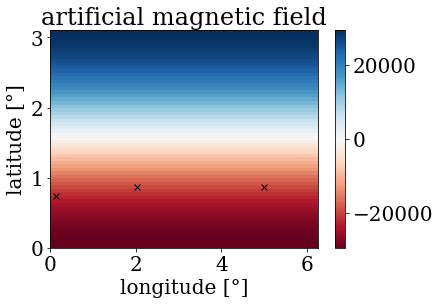

In [8]:
# Random colatitude and longitude.
#theta=np.random.rand(3)*np.pi
#phi=np.random.rand(3)*np.pi*2.0

# Observation points.
# Zurich, New York, Beijing
theta=np.array([0.744,0.860,0.87])
phi=np.array([0.149,4.99,2.024])

# Maximum harmonic degree and Gauss coefficients.
n=1
g=np.zeros((n+1,n+1))
h=np.zeros((n+1,n+1))
g[1,0]=-29442.0

# Compute the magnetic field values for the observation points.
d_obs=B(phi,theta,g,h).diagonal()

# Plot magnetic field and measurements points on a map. 
# For this, the magnetic field is recomputed on a dense grid of points.
theta_plot=np.arange(0.0,np.pi,0.05)
phi_plot=np.arange(0.0,2.0*np.pi,0.05)

d_plot=B(phi_plot,theta_plot,g,h)

colat,lon=np.meshgrid(phi_plot,theta_plot)
plt.pcolor(colat,lon,d_plot, cmap=plt.cm.get_cmap('RdBu'))
plt.plot(phi,theta,'kx')
plt.colorbar()
plt.xlabel('longitude [°]')
plt.ylabel('latitude [°]')
plt.title('artificial magnetic field')
plt.show()

# 3. Priors in data and model space

In order to solve a Bayesian inference problem, we require prior probabilities in data and model space, that is, $\rho(d|m)$ and $\rho(m)$. For convenience, we implement them as simple functions. $$ $$

** Exercise 2**: Plot the data prior defined below for $d_{obs}=0$.

The key prior information on the spherical harmonics coefficients is that the energy of the magnetic field must be finite. The energy $E$ is equal to the squared sum of all coefficients, that is, $\sum_{n=0}^\infty \sum_{m=0}^n [(g_n^m)^2+(h_n^m)^2]$. $$ $$

** Exercise 3**: Plot the model prior defined below as a function of the energy $E$.

In [9]:
def prior_data(d_obs,d):
    
    sigma1=2000.0
    sigma2=2500.0
    shift1=0.0
    shift2=2000.0
    return np.exp(-0.5*norm(d-d_obs-shift1)**2/sigma1**2)#+0.25*np.exp(-0.5*norm(d-d_obs-shift2)**2/sigma2**2)

def prior_model(g,h):
    
    E=np.sum(g**2+h**2)
    E0=30000.0**2
    sigma=10000.0**2
    return np.exp(-0.5*(E-E0)**2/sigma**2)

# 4. Sampling the 1D posterior by grid search

To obtain the posterior distribution, we evaluate Bayes' theorem systematically via a grid search.

**Exercise 4**: Sample the posterior by running the code below and discuss the results. (What is the value of the maximum-likelihood coefficient? Provide a visual guess of the standard deviation. Does the posterior have more than one peak?) Compare your result with the results of your colleagues, who may have a more or less favourable distribution of sampling points.

**Exercise 5**: Repeat the probabilistic inversion with just observation point. How does the reduction of observation points affect the quality of your inference?

**Exercise 6** Repeat the inversion with 20 observation points. How does the increase of observation points affect the quality of your inference?

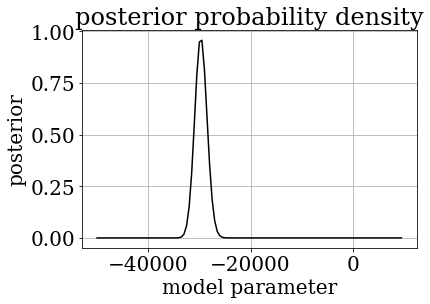

In [10]:
# Initialise the values for which to evaluate the posterior.
g10=np.arange(-50000.0,10000.0,500.0)
posterior=np.zeros(len(g10))

# March through all test values and evaluate the posterior by computing test data.
for i in range(len(g10)):
    g[1,0]=g10[i]
    
    d=B(phi,theta,g,h).diagonal()
    posterior[i]=prior_model(g,h)*prior_data(d,d_obs)
    
# Plot the posterior.    
plt.plot(g10,posterior,'k')
plt.xlabel('model parameter')
plt.ylabel('posterior')
plt.title('posterior probability density')
plt.grid()
plt.show()

# 5. Sampling in 2D

To make the inversion a bit more complicated, we try to infer 2 spherical harmonic coefficients, namely $g_1^0$ and $g_1^1$. All other coefficients are assumed to be $0$. $$ $$

**Exercise 7**: Generate synthetic data of the magnetic field for $g_1^0=-29442.0$ and $g_1^1=-1501.0$ at 3 random locations on the Earth's surface by running the code below. Note the coordinates of the observation points and the corresponding magnetic field values. $$ $$

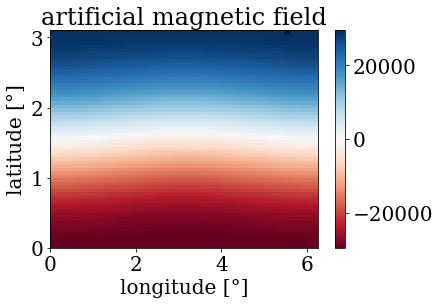

In [16]:
# Random colatitude and longitude.
theta=np.random.rand(1)*np.pi
phi=np.random.rand(1)*np.pi*2.0

# Observation points.
# Zurich, New York, Beijing
#theta=np.array([0.744,0.860,0.87])
#phi=np.array([0.149,4.99,2.024])

# Maximum harmonic degree and Gauss coefficients.
n=1
g=np.zeros((n+1,n+1))
h=np.zeros((n+1,n+1))
g[1,0]=-29442.0
g[1,1]=-1501.0

# Compute the magnetic field values for the observation points.
d_obs=B(phi,theta,g,h).diagonal()

# Plot magnetic field and measurements points on a map. 
# For this, the magnetic field is recomputed on a dense grid of points.
theta_plot=np.arange(0.0,np.pi,0.05)
phi_plot=np.arange(0.0,2.0*np.pi,0.05)

d_plot=B(phi_plot,theta_plot,g,h)

colat,lon=np.meshgrid(phi_plot,theta_plot)
plt.pcolor(colat,lon,d_plot, cmap=plt.cm.get_cmap('RdBu'))
plt.plot(phi,theta,'kx')
plt.colorbar()
plt.xlabel('longitude [°]')
plt.ylabel('latitude [°]')
plt.title('artificial magnetic field')
plt.show()

**Exercise 8**: Using the same data and model priors as before, we evaluate the posterior via a systematic grid search of all plausible values for $g_1^0$ and $g_1^1$. For this, run the code below and analyse the posterior distribution. $$ $$

**Exercise 9**: Repeat the inversion with 1 observation point. Can the two coefficients still be constrained independently? Compare your results with those of your colleagues.

**Exercise 10**: How much time is needed to invert for the 2 coefficients with 3 observation points? How does this time compare to the inversion for just 1 coefficient? For how many parameters do you think you can invert in less than 1 hour? Is grid search a feasible approach to the solution of large probabilistic inverse problems?

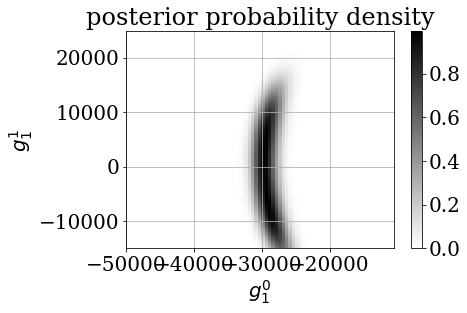

In [17]:
# Initialise the values for which to evaluate the posterior.
g10=np.arange(-50000.0,-10000.0,500.0)
g11=np.arange(-15000.0,25000.0,100.0)
posterior=np.zeros((len(g10),len(g11)))

# March through all test values and evaluate the posterior by computing test data.
for i in range(len(g10)):
    for j in range(len(g11)):
        g[1,0]=g10[i]
        g[1,1]=g11[j]
        
        d=B(phi,theta,g,h).diagonal()
        posterior[i,j]=prior_model(g,h)*prior_data(d,d_obs)

g10,g11=np.meshgrid(g11,g10)
plt.pcolor(g11,g10,posterior, cmap=plt.cm.get_cmap('binary'))
plt.xlabel(r'$g_1^0$')
plt.ylabel(r'$g_1^1$')
plt.colorbar()
plt.title('posterior probability density')
plt.grid()
plt.show()

# 6. Spectral leakage

The real magnetic field has, of course, infinitely many spherical harmonic coefficients. However, since our computational resources are finite, we have to truncate the expansion after a finite number of coefficients. The neglect of higher-order coefficients tends to pollute the lower-order coefficients that we wish to infer as accurately as possible. This phenomenon is referred to as *spectral leakage*. (The higher-order coefficients leak into the lower-order coefficients.)

**Optional exercise 11**: Generate synthetic data for 2 coefficients. Then invert these data under the assumption that only $g_1^0$ is different from $0$. Is it possible to obtain reliable results? $$ $$